# Predicting job churn

## Project definition

### Overview

- A company that relies on Big Data wants to hire data scientists among candidates that sign up for a special training they provide. 
- The objetive is to predict the probability that an enrollee will want to work for the company after the training or will start looking for a new job.
- This information is useful for the company as it helps to plan training courses as to reduce the cost and time and control for the quality of sessions.
- Current credentials, demographics and experience data is provided for each enrollee, as well as a target variable that indicates wether a candidate is not looking for a new job (0) or is looking for a job (1).
- The dataset comes from [Kaggle](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists).

### Features

- `enrollee_id:` Unique ID for candidate
- `city:` City code
- `city_development_index:` Developement index of the city (scaled)
- `gender:` Gender of candidate
- `relevent_experience:` Relevant experience of candidate
- `enrolled_university:` Type of University course enrolled if any
- `education_level:` Education level of candidate
- `major_discipline:` Education major discipline of candidate
- `experience:` Candidate total experience in years
- `company_size:` No of employees in current employer's company
- `company_type:` Type of current employer
- `lastnewjob:` Difference in years between previous job and current job
- `training_hours:` training hours completed
- `target:` 0 – Not looking for job change, 1 – Looking for a job change

### Problem

- Estimate the probability that a candidate will start looking for a new job after the training.

### Solution

- A machine learning XGboost model will be fitted on the data to estimate the probabilities of enrollees looking for a new job after the completion of their special training.

### Metrics

- The model evaluation metric will be the [Area Under the Receiver Operating Characteristic Curve (ROC AUC)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

- After model evaluation, AUC scores will be benchmakred against other models trained on the same data.


## Exploratory Data Analysis (EDA) of raw data

In [5]:
# Install plotnine if missing
!pip install plotnine

     |████████████████████████████████| 4.4 MB 26.8 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 403 kB/s  eta 0:00:01
     |████████████████████████████████| 111 kB 61.6 MB/s eta 0:00:01


In [6]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *

A train and test set have been provided, the test data has no target info. In this section we will explore relevant charateristics of the data.

- **Shape of train and test sets:**

In [23]:
# Load raw data
dir_raw_data = 'data/raw'
train = pd.read_csv(os.path.join(dir_raw_data, 'aug_train.csv'))
test = pd.read_csv(os.path.join(dir_raw_data, 'aug_test.csv'))
print("Train shape: " + str(train.shape[0]) + " rows, and " +  str(train.shape[1]) + " columns")
print("Test shape: " + str(test.shape[0]) + " rows, and " +  str(test.shape[1]) + " columns")

Train shape: 19158 rows, and 14 columns
Test shape: 2129 rows, and 13 columns


As mentioned the test set is missing the target field.

### Fields and data types

In [111]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

### Number of unique enrollees by dataset

In [112]:
print("Unique enrollees in train dataset: " + str(len(train.enrollee_id.unique())))
print("Unique enrollees in test dataset: " + str(len(test.enrollee_id.unique())))

Unique enrollees in train dataset: 19158
Unique enrollees in test dataset: 2129


10 out of 14 fields are categorical and the reamining 4 are numerical.

### Target descriptions

In [113]:
df_target_counts = train[['target']].value_counts().reset_index().rename(columns = {0: 'counts'})
df_target_counts['target'] = df_target_counts.target.astype('object')
df_target_counts['percent'] = train.target.value_counts(normalize=True).round(2).mul(100)
df_target_counts

,target,counts,percent
0,0,14381,75.0
1,1,4777,25.0


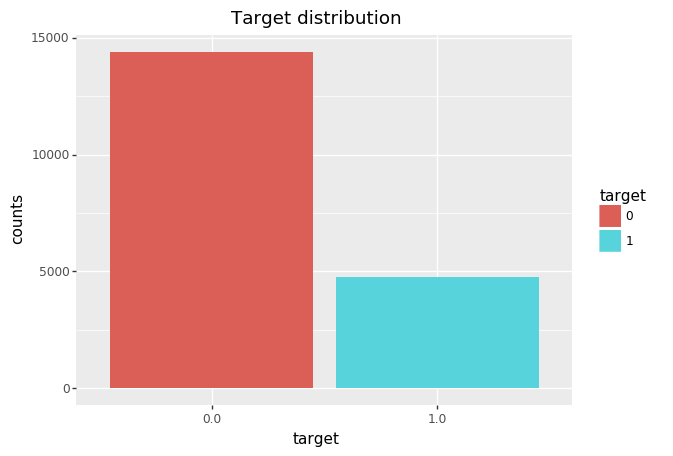

<ggplot: (8788917301256)>

In [114]:
( 
    ggplot( df_target_counts, aes(x = 'target', y = 'counts', fill = 'target') ) + 
    geom_col() +
    labs(title =  "Target distribution")
)

It is a highly imbalanced target, for each enrollee that wants to look for a new job, there are three that are staying.

### Missing values

In [115]:
df_train_missing_vals = train.isna().sum().reset_index().rename( columns = {'index': 'fields', 0: 'counts'}).sort_values(by = 'counts', ascending = False)
df_train_missing_vals['percent'] = round(df_train_missing_vals.counts / train.shape[0], 2)*100
df_train_missing_vals

,fields,counts,percent
10,company_type,6140,32.0
9,company_size,5938,31.0
3,gender,4508,24.0
7,major_discipline,2813,15.0
6,education_level,460,2.0
11,last_new_job,423,2.0
5,enrolled_university,386,2.0
8,experience,65,0.0
0,enrollee_id,0,0.0
1,city,0,0.0


* There are missing values in the dataset. The fields `company_type`, `company_size`, `gender` and `major_discipline` are the fields that have more than 15% of their values missing. 

* `Education_level`, `enrolled_university` and `last_new_job` have only 2% values missing.

* An imputation strategy should be used such as the mode or trying aggregate them in other category.

### Visualizations

In [116]:
def plot_categorical_fields(df, variable):
    '''
    This function creates barplots for all categorical data.
    df: dataframe
    variable: categorical data to plot
    Returns a plotnine object
    '''
    df = df.assign(counts = 1)
    df[variable] = df[variable].fillna("Missing")
    df.groupby([variable, 'target'])['counts'].sum()
    df = pd.DataFrame(df).reset_index()
    df['target'] = df.target.astype('category')
    gg = (
        ggplot( df, aes( x = variable, y = 'counts', fill = 'target') ) +
        geom_col() +
        labs( title = 'Target vs: ' + variable)
    )
    gg.draw()

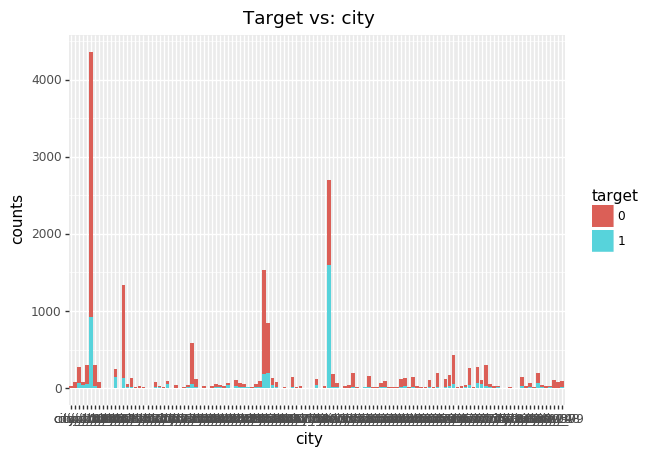

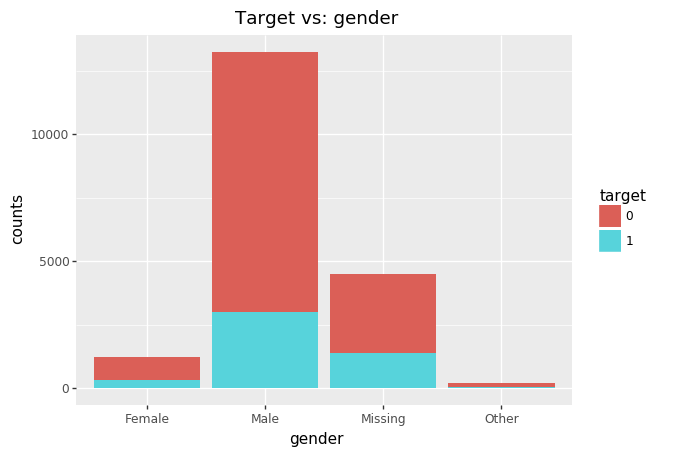

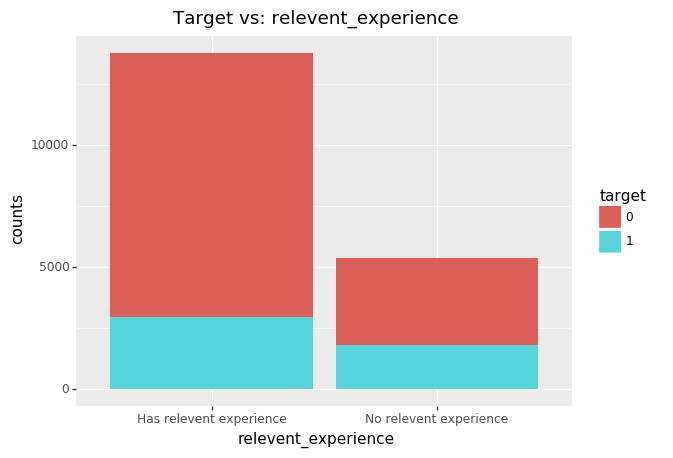

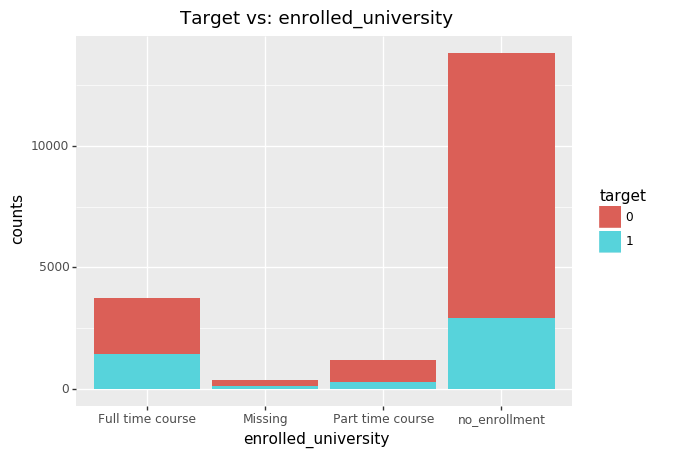

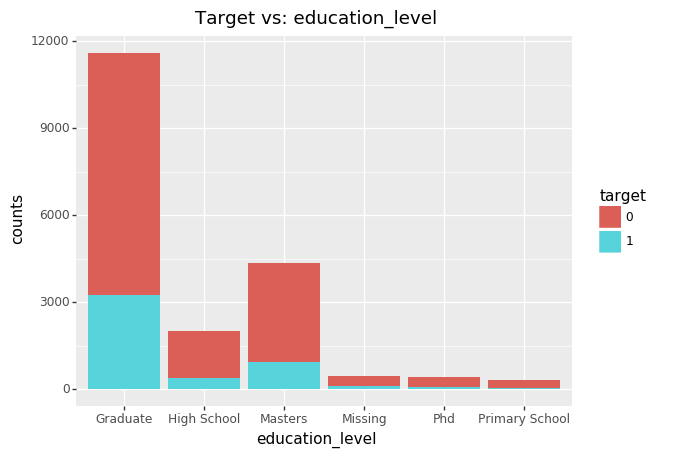

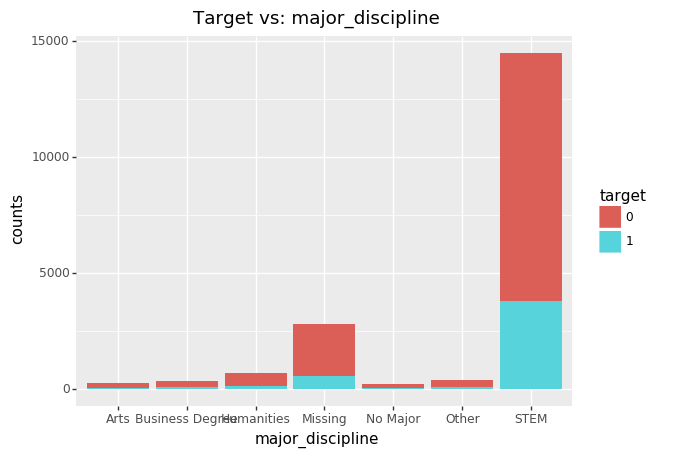

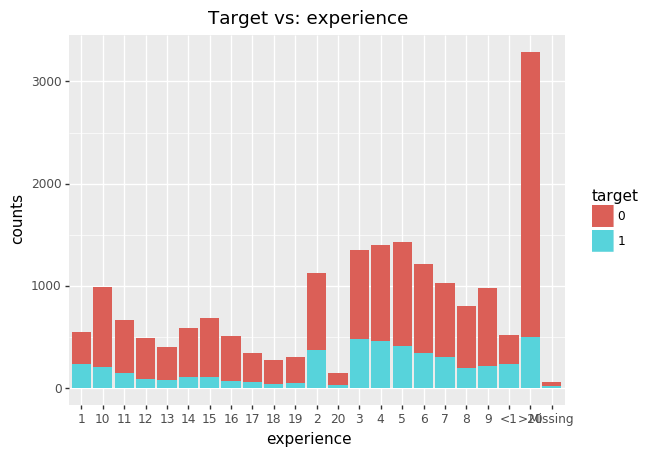

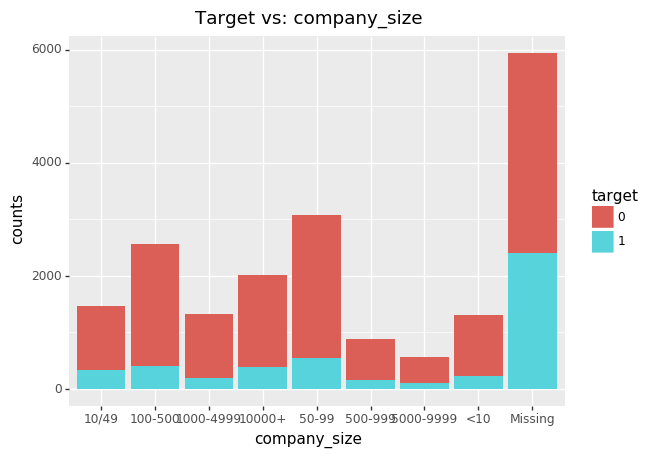

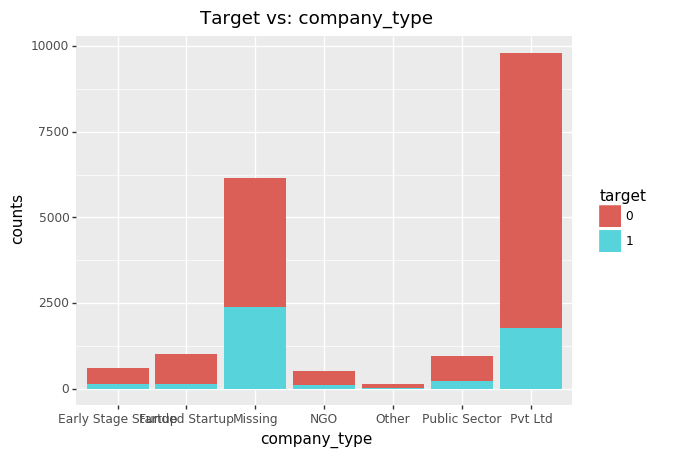

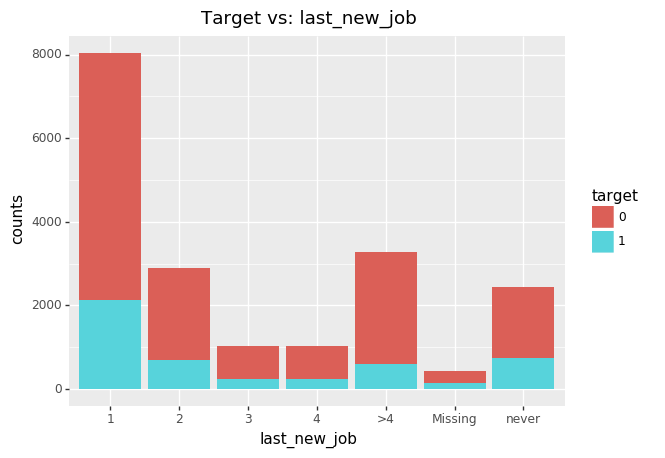

In [117]:
for field in train.dtypes[(train.dtypes == 'object') | (train.dtypes == 'category') ].index:
    plot_categorical_fields(train, field)

### A few observations by fields:

- `city:` It is very hetrogeneous, there are 6 cities with more observations than others.
- `gender:` There are more males than females, but also missing genders is high enough. Missing genders could be aggregated with others.
- `relevant_experience:` There is people with more relevant experience than others, but in terms of who wants to stay and who wants to leave there is no clear pattern.
- `enrolled_university:` There are more enrollees not enrolled in university, I will assume they are professionals. Missing values can be aggregated to no_enrollment.
- `eductaion_level:` Most of the enrollees are graduates and have a postgraduate. There are many other education levels that could be aggregated to have more general categories.
- `major_discipline:` Most enrollees come from STEM major disciplines. The rest show very few records. Major disciplines could be aggregated into more general ones.
- `experience:` There are more enrollees with less than or equal to 9 years of experience than with more than 9 years of experience. It is more likely that people with less years of experience choose to look for a new job. This variable could also be aggregated into more general values.
- `company_type:` Most of the enrollees work for private sector, however the number of records with missing data are too many. Missing and other company type could be aggregated. The rest of the types could be aggregated into more general ones.
- `company_size:` Most other enrollees did not indicate company size, they could be aggregated into the less than 10 category. This field is a bit dirty; it could be aggregated into more general categories. Apparently, enrollees with missing values tend to look for a new job.
- `last_new_job:` Most of the enrollees are on their first job. It less likely that people with more years of experience look for a new job. Missing and never could be aggregated.

## Preprocessing

**Clean data**

- Aggregate categories within fields. 
- Missing values are aggregated as descripted above.
- Converts all values into lower case and removes spaces.

In [20]:
def clean_data(df):
    '''
    The function cleans each field in the dataset.
    It receives a raw dataset and returns a clean dataset.
    In general it converts each value to lower case, removes empty spaces, relabels values such as missing values. 
    It aggregates categories. For orginal categorical variables it specifies the order of each category.
    '''
    # copy dataframe
    df = df.copy()
    # gender
    df['gender'] = df.gender.fillna("Other").str.lower()
    # enrolled univeristy
    df['enrolled_university'] = df.enrolled_university.fillna("no_enrollment").str.lower().str.replace(r'\s',"_")
    # erolled_university
    df['relevent_experience'] = df.relevent_experience.str.lower().str.replace(r'\s',"_")
    # education_level
    df['education_level'] = (
        df.education_level
            .str.lower()
            .str.replace(r'\s',"_")
            .replace('primary_school', 'not_graduate')
            .replace('high_school', 'not_graduate')
            .replace('masters', 'post_graduate')
            .replace('phd', 'post_graduate')
            .replace(np.nan, 'not_graduate')
            .astype('category').cat.reorder_categories(['not_graduate', 'graduate','post_graduate'], ordered=True)
    )
    # major discipline
    df['major_discipline'] = (
        df.major_discipline
            .str.lower()
            .str.replace(r'\s',"_")
            .replace('humanities', 'not_stem')
            .replace('business_degree', 'not_stem')
            .replace('arts', 'not_stem')
            .replace('no_major', 'other')
            .replace(np.nan, 'other')
    )
    # experience
    df.experience.loc[ 
        (df.experience == '<1') | (df.experience == '1') | (df.experience == '2') | 
        (df.experience == '3') | (df.experience == '4') | (df.experience == '5') ] = 'less_or_equal_than_5'
    df.experience.loc[ 
        (df.experience == '6') | (df.experience == '7') | (df.experience == '8') | 
        (df.experience == '9') | (df.experience == '10') ] = 'less_or_equal_than_10'
    df.experience.loc[ 
        (df.experience == '11') | (df.experience == '12') | (df.experience == '13') | 
        (df.experience == '14') | (df.experience == '15') ] = 'less_or_equal_than_15'
    df.experience.loc[ 
        (df.experience == '16') | (df.experience == '17') | (df.experience == '18') | 
        (df.experience == '19') | (df.experience == '20') ] = 'less_or_equal_than_15'
    df.experience.loc[ df.experience == '>20'] = 'greater_than_20'
    df['experience'] = (
        df.experience
            .fillna('less_or_equal_than_5')
            .astype('category').cat.reorder_categories(
                ['less_or_equal_than_5', 'less_or_equal_than_10',
                 'less_or_equal_than_15', 'greater_than_20'], ordered=True)
    )
    # company_type
    df['company_type'] = (
        df.company_type
            .str.lower()
            .str.replace(r'\s',"_")
            .replace('funded_startup', 'startup')
            .replace('early_stage_startup', 'startup')
            .replace('public_sector', 'government_or_ngo')
            .replace('ngo', 'government_or_ngo')
            .replace('no_major', 'other')
            .replace(np.nan, 'other')
    )
    # company size
    df.company_size.loc[ 
        (df.company_size == '<10') | (df.company_size == '10/49') | 
        (df.company_size == '50-99') ] = 'less_or_equal_than_99'
    df.company_size.loc[ 
        (df.company_size == '100-500') | (df.company_size == '500-999') | 
        (df.company_size == '50-99') ] = 'less_or_equal_than_999'
    df.company_size.loc[ 
        (df.company_size == '1000-4999') | (df.company_size == '5000-9999') | 
        (df.company_size == '10000+') ] = 'greater_than_999'
    df['company_size'] = (
        df.company_size
            .fillna('missing')
            .astype('category')
            .cat.reorder_categories(
                ['less_or_equal_than_99', 'less_or_equal_than_999',
                 'greater_than_999', 'missing'], ordered=True)
    )
    # last_new_job
    df['last_new_job'] = (
        df.last_new_job.fillna('never')
            .replace('1', 'less_or_equal_than_1')
            .replace('2', 'less_or_equal_than_2')
            .replace('3', 'less_or_equal_than_4')
            .replace('4', 'less_or_equal_than_4')
            .replace('>4', 'more_than_4')
            .astype('category')
            .cat.reorder_categories(
                ['never','less_or_equal_than_1', 'less_or_equal_than_2', 
                 'less_or_equal_than_4', 'more_than_4'], ordered=True)
    )

    return df

In [119]:
cleaned_train = clean_data(train)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


- **Select features to be included in the design matrix**

All variables are selected except enrollee id and city. For city we are using the city_development_index as it is more informative.

In [21]:
categorical_fields = [
    'gender', 'relevent_experience', 'enrolled_university', 'education_level', 
    'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job'
]

numerical_fields = [
    'city_development_index',
    'training_hours'
]

- **One Hot Encode categorical variables.**

We one hot encode all categorical variables and concatenate the new matrix with the numerical matrix, to yield the final design matrix.

In [121]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit( cleaned_train[categorical_fields] )
categorical_matrix = one_hot_encoder.transform( cleaned_train[categorical_fields] ).toarray()
numeric_matrix = cleaned_train[numerical_fields].values
X_train_array = np.concatenate((categorical_matrix, numeric_matrix), axis = 1)
y_train_array = cleaned_train['target'].astype('int64').values

In [122]:
print(X_train_array.shape)
print(y_train_array.shape)

(19158, 33)
(19158,)


After recoding and one hot encoding there are 33 fields.

- **Split the training data into training and validation data**

    + Training is 75%
    + Validation is 25%
    + Splitting is stratified by the target variable to preserve the same proportions in training and validation dataset.

In [123]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split( X_train_array, y_train_array, test_size=0.25, random_state=42 )

In [124]:
print("Training set:")
print("Rows: " + str( X_train.shape[0]) + " Columns: " + str( X_train.shape[1]))

print("\nValdiation set:")
print("Rows: " + str( X_val.shape[0]) + " Columns: " + str( X_val.shape[1]))

Training set:
Rows: 14368 Columns: 33

Valdiation set:
Rows: 4790 Columns: 33


- **Clean the testing set**

The same process for training set is repeated on the testing set.

In [25]:
cleaned_test = clean_data(test)

In [126]:
categorical_matrix = one_hot_encoder.transform( cleaned_test[categorical_fields] ).toarray()
numeric_matrix = cleaned_test[numerical_fields].values
X_test_array = np.concatenate((categorical_matrix, numeric_matrix), axis = 1)

In [127]:
print(X_test_array.shape)

(2129, 33)


### Upload data S3

The preprocessed training, validation and testing datasets are stored in csv files locally, and then are uploaded to S3.

**Save preprocessed data locally**

In [128]:
dir_preprocessed_data = 'data/preprocessed'

if not os.path.exists(dir_preprocessed_data): # Make sure that the folder exists
    print("Creating directory for preprocessed data ...")
    os.makedirs(dir_preprocessed_data)

# Save training dataset
(
    pd.concat([pd.DataFrame(y_train), pd.DataFrame(X_train)], axis = 1)
        .to_csv( os.path.join(dir_preprocessed_data, 'train.csv'), 
                header=False, 
                index=False)
)

# Save validation dataset
(
    pd.concat([pd.DataFrame(y_val), pd.DataFrame(X_val)], axis = 1)
        .to_csv( os.path.join(dir_preprocessed_data, 'validation.csv'), 
                header=False, 
                index=False)
)
# Save test dataset
(
    pd.concat([pd.DataFrame(X_test_array)], axis = 1)
        .to_csv( os.path.join(dir_preprocessed_data, 'test.csv'), 
                header=False, 
                index=False)
)

It might be necessary to update the sagemaker library. If necessary uncomment the code an run.

In [129]:
# Update sagemaker if necessary
#!pip install -U sagemaker

In [130]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/predicting_job_change'

role = sagemaker.get_execution_role()

In [131]:
train_location = sagemaker_session.upload_data( os.path.join(dir_preprocessed_data, 'train.csv'), key_prefix=prefix)
val_location = sagemaker_session.upload_data( os.path.join(dir_preprocessed_data, 'validation.csv'), key_prefix=prefix)
test_location = sagemaker_session.upload_data( os.path.join(dir_preprocessed_data, 'test.csv'), key_prefix=prefix)

## Train and test models

- Two xgboost models are going to be fitted using a different tuning parameter on the optimization target. The first model is going to be optimized by accuracy and the second by area under the curve score.

### xgboost optimized on accuracy

**Train**

* Sagemaker implementation for xgboost is used.

In [132]:
# get the container for xgboost
xgboost_container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-1")

# construct a SageMaker estimator
xgb = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          role=role,
                                          instance_count=1, 
                                          instance_type='ml.m4.xlarge', 
                                          output_path='s3://{}/{}/output'.format(sagemaker_session.default_bucket(), prefix),
                                          sagemaker_session=sagemaker_session)
# set hyperparameters
xgb.set_hyperparameters(max_depth=5,
                        eta=0.1,
                        gamma = 3,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        num_round=1000)

* To control overfitting, hyper-paramater tuning is applied choosing from a reasonable range of values for max depth, eta, min child weight, gamma and subsample

In [133]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator=xgb, 
                                               objective_metric_name='validation:accuracy',
                                               objective_type='Maximize',
                                               max_jobs = 20,
                                               max_parallel_jobs = 3,
                                               hyperparameter_ranges= {
                                                  'max_depth': IntegerParameter(3,8),
                                                  'eta' : ContinuousParameter(0.001, 1),
                                                  'gamma' : ContinuousParameter(0, 5),
                                                  'min_child_weight': IntegerParameter(2,6),
                                                  'subsample': ContinuousParameter(0.5,0.9),
                                                  'colsample_bytree': ContinuousParameter(0.5,1) 
                                               })

In [ ]:
s3_input_train = TrainingInput(train_location, content_type='csv')
s3_input_validation = TrainingInput(val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

xgb_hyperparameter_tuner.wait()

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
!


* The best performing model was.

In [ ]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-210309-0631-012-711c78e7'

* The best estimator is used to create a batch transform job to test our model. Deployment of the model in a web app is not considered, as the business will provide batch data every period of time, on a low frequency period.

In [ ]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())


2021-03-09 06:52:44 Starting - Preparing the instances for training
2021-03-09 06:52:44 Downloading - Downloading input data
2021-03-09 06:52:44 Training - Training image download completed. Training in progress.
2021-03-09 06:52:44 Uploading - Uploading generated training model
2021-03-09 06:52:44 Completed - Training job completed


**Test**

* A testing batch job is created to obtain predictions for the testing dataset of enrollees.

In [ ]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [ ]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

.......................................
[2021-03-09:07:16:11:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-09:07:16:11:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-09:07:16:11:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


2021/03/09 07:16:11 [crit] 20#20:

In [ ]:
xgb_transformer.wait()

[2021-03-09:07:16:11:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-09:07:16:11:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-09:07:16:11:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

[2021-03-09:07:16:11:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-09:07:16:11:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-09:07:16:11:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameter

* A directory in S3 is created to store predictions.

In [8]:
dir_sagemaker_predictions = 'data/sagemaker_predictions'

if not os.path.exists(dir_sagemaker_predictions): # Make sure that the folder exists
    print("Creating directory for sagemaker predictions ...")
    os.makedirs(dir_sagemaker_predictions)

* Predictions are copied from S3 to local machine for further analysis.

In [ ]:
!aws s3 cp --recursive $xgb_transformer.output_path $dir_sagemaker_predictions/xgboost_acurracy

download: s3://sagemaker-us-east-1-663209323204/sagemaker-xgboost-2021-03-09-07-09-48-520/test.csv.out to data/sagemaker_predictions/xgboost_acurracy/test.csv.out


### xgboost optimized on auc

* The second xgboost model is fitted optimizing on the AUC metric.

**Train**

In [ ]:
# get the container for xgboost
xgboost_container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-1")

# construct a SageMaker estimator
xgb2 = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          role=role,
                                          instance_count=1, 
                                          instance_type='ml.m4.xlarge', 
                                          output_path='s3://{}/{}/output'.format(sagemaker_session.default_bucket(), prefix),
                                          sagemaker_session=sagemaker_session)
# set hyperparameters
xgb2.set_hyperparameters(max_depth=5,
                        eta=0.1,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        gamma = 3,
                        num_round=1000)

In [ ]:
xgb_hyperparameter_tuner2 = HyperparameterTuner(estimator=xgb2, 
                                               objective_metric_name='validation:auc',
                                               objective_type='Maximize',
                                               max_jobs = 20,
                                               max_parallel_jobs = 3,
                                               hyperparameter_ranges= {
                                                  'max_depth': IntegerParameter(3,8),
                                                  'eta' : ContinuousParameter(0.001, 1),
                                                  'gamma' : ContinuousParameter(0, 5),
                                                  'min_child_weight': IntegerParameter(2,6),
                                                  'subsample': ContinuousParameter(0.5,0.9),
                                                  'colsample_bytree': ContinuousParameter(0.5,1) 
                                               })

In [ ]:
xgb_hyperparameter_tuner2.fit({'train': s3_input_train, 'validation': s3_input_validation})

xgb_hyperparameter_tuner2.wait()

...................................................................................................................................................................................................................................................................................................................................................................................................................!
!


In [ ]:
xgb_hyperparameter_tuner2.best_training_job()

'sagemaker-xgboost-210309-0716-012-22b700b0'

In [ ]:
xgb_attached2 = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner2.best_training_job())


2021-03-09 07:37:05 Starting - Preparing the instances for training
2021-03-09 07:37:05 Downloading - Downloading input data
2021-03-09 07:37:05 Training - Training image download completed. Training in progress.
2021-03-09 07:37:05 Uploading - Uploading generated training model
2021-03-09 07:37:05 Completed - Training job completed


**Test**

* A tesing batch job is created to obtain predictions.

In [ ]:
xgb_transformer2 = xgb_attached2.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
xgb_transformer2.transform(test_location, content_type='text/csv', split_type='Line')

......................................[2021-03-09:07:56:48:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-09:07:56:48:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-09:07:56:48:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


2021/03/09 07:56:48 [crit] 20#20: *

* Predictions are passed from S3 to local machine for analysis.

In [ ]:
!aws s3 cp --recursive $xgb_transformer2.output_path $dir_sagemaker_predictions/xgboost_auc

download: s3://sagemaker-us-east-1-663209323204/sagemaker-xgboost-2021-03-09-07-50-36-492/test.csv.out to data/sagemaker_predictions/xgboost_auc/test.csv.out


## Evaluation

* In this section we compare the results of both xgboost probability predictions for enrolles looking for a job change. The estalbished comparison criteria is the Area Under the Curve (AUC) as stated in the Kaggle's problem description. 

* The AUC of these models is compared to the AUC scores obtained [Joshua Swords](https://www.kaggle.com/joshuaswords/awesome-hr-data-visualization-prediction) using the following models: SVC, Decision Tree, Random Forest, Logistic Regression and KNN.



### Distribution of probabilities.

* The two models are very similar. However the xgboost tuned to reach better accuracy, returned a set of probabilities with a narrower distribution than the  xgboost tuned for better AUC.

In [27]:
y_test_pred_xgboost_accuracy = pd.read_csv(os.path.join(dir_sagemaker_predictions, 'xgboost_acurracy/test.csv.out'), header = None ).values.reshape(1,-1)[0]
y_test_pred_xgboost_auc = pd.read_csv(os.path.join(dir_sagemaker_predictions, 'xgboost_auc/test.csv.out'), header = None ).values.reshape(1,-1)[0]
y_test_true = np.load('data/raw/jobchange_test_target_values.npy')

In [28]:
df_model_probs = pd.concat([
    pd.DataFrame({'prob':y_test_pred_xgboost_accuracy, 'model': 'xgboost_accuracy'}),
    pd.DataFrame({'prob':y_test_pred_xgboost_auc, 'model': 'xgboost_auc'})
])

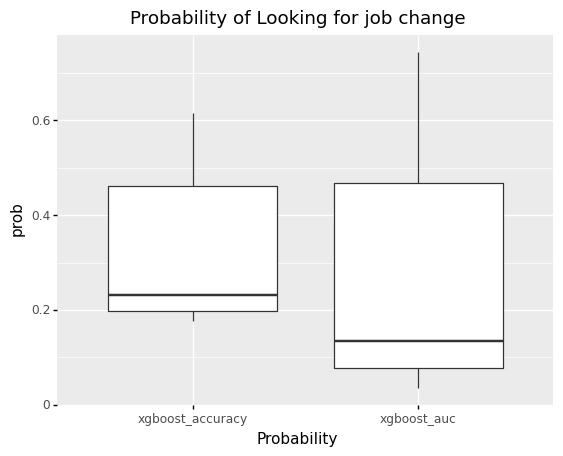

<ggplot: (8768228687126)>

In [29]:
( 
    ggplot( df_model_probs, aes( x = 'model', y = 'prob')) + 
    geom_boxplot() + 
    #facet_wrap(facets='~model') +
    labs(title = 'Probability of Looking for job change', x = 'Probability') 
)

### ROC Curves and AUC

* Estimating the ROC curves it can be seen that both models a very similar classifiers. Their AUC curves are almost perfectly overlapped. 
* At this point it can be said that both models will do the job of yielding very similar probability predictions for employee turn over.

In [31]:
from sklearn import metrics

In [32]:
def get_roc_curve_dataframe(y_test_true, y_test_pred, model_name):
    '''
    Returns a data frame with the fpr, tpr, thresholds and model name
    '''
    fpr, tpr, thresholds = metrics.roc_curve(y_test_true, y_test_pred)
    return(pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds':thresholds, 'model': model_name}))

In [33]:
df_roc_curve = pd.concat(
    [get_roc_curve_dataframe(y_test_true, y_test_pred_xgboost_accuracy, 'xgboost_accuracy'),
     get_roc_curve_dataframe(y_test_true, y_test_pred_xgboost_auc, 'xgboost_auc')]
)

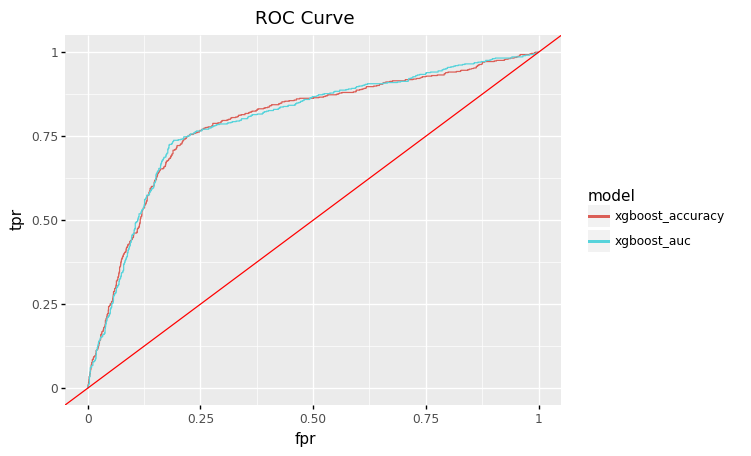

<ggplot: (8768228753051)>

In [34]:
(
    ggplot( df_roc_curve, aes( x = 'fpr', y = 'tpr', color = 'model') ) +
    geom_path( ) +
    geom_abline(slope = 1, intercept = 0, color = 'red') +
    labs( title = 'ROC Curve')
)

* Below the AUC score is calculated, and it can be seen that both models yield 79% of AUC score, where 100% is the maximum.

**AUC score for xgboost tuned for better accuracy.**

In [35]:
print("Area under the curve Acurracy: {}".format(round(metrics.roc_auc_score(y_test_true, y_test_pred_xgboost_accuracy), 2)))

Area under the curve Acurracy: 0.79


**AUC score for xgboost tuned for better AUC score.**

In [36]:
print("Area under the curve AUC: {}".format(round(metrics.roc_auc_score(y_test_true, y_test_pred_xgboost_auc), 2)))

Area under the curve AUC: 0.79


* In order to assess wether these models perform well, they will be compared against other models estimated on the same data.

### AUC scores vs Benchmarks

- The following table contains the model performance metrics that [Joshua Swords](https://www.kaggle.com/joshuaswords/awesome-hr-data-visualization-prediction) obtained using SVC, Decision Tree, Random Forest, Logistic Regression and KNN using the same data. In the columns he presents 4 evaluation metrics, accracy, recall, precision and ROC AUC score. In each row he presents the scores of each model conditional on the evaluation metric.

* The ROC AUC scores he obtained are in the range of 54.3% to 65%. The best performing model was a Random Forest.

<img src="fig/benchmarks.png">

* The XGboost model implemented in this project is well known to achieve superior results than any of the rest of the models presented in the table above. 

* The ROC AUC scores of the two XGboosts estimated outperformed by almost 10% points the Random Forest.

* The XGboosts were tuned for maximum accuracy and ROC AUC score after hyper parameter tuning. Both models seem to be almost identical as how they separate both classes, no matter the threshold used.

* Both models can be implemented for the task at hand. 

* At this point, wether these models are good enough, will depend on how useful they will be for Human Resources making decisions in the real world.

## Conclusions and final output

- In this project, machine learning is used to help a given company that is specialized in Big Data, to estimate the probabilities of enrollees with special training that will look for a new job outside the company after completing their courses.

- Two XGboost models are fitted and tuned to obtain the best predictions for probabilities. Compared to other models trained on the same dataset, the Xgboost models outperformed the other by almost 10% points.

- Both XGboost models yield the same AUC score, so any of them could be used.

- In the process of estimation sagemaker built in models were used, and hyperparameter grid search was applied to control for overfitting. 

- The training set was split into a validation set, in order to ensure that appropriate model validation was applied.

- The following list contains the probabilities of looking for a new job for each of the employees. Using the Xgboost tuned for AUC score, that will be handed in to the HR area. This probabilities were selected rather than the others for no particular reason as they are very similar according to the evaluation metric at hand, but because the AUC score is the evaluation metric that matters these probabilies come from a model that is tuned for better AUC scores.

In [38]:
pd.concat([cleaned_test[['enrollee_id']], pd.DataFrame({'prob':y_test_pred_xgboost_auc}).round(2)], axis = 1).head(100)

,enrollee_id,prob
0,32403,0.14
1,9858,0.30
2,31806,0.43
3,27385,0.07
4,27724,0.08
...,...,...
95,2934,0.05
96,12919,0.58
97,4386,0.53
98,22462,0.62


Depending on the costs that the company incurs on recuiting candidates and imparting training sessions, they can use these probabilities for decision making.

- Segment their enrollees and work with the best candidates that wish to look for a new job, in order to retain them.
- Improve their training in order to reduce the probabilities of looking for a new job outside the company.
- Focus futher efforts on candidates that want to stay in the company.

These are some of the possibilites on how these probabilites can be used.

## Clean up

The following code deletes results from workspace in S3.

In [ ]:
# First remove all of the files contained in the data_dir directory
!rm $sagemaker_session/prefix/*

# And then we delete the directory itself
!rmdir $sagemaker_session/prefix